# **Understanding The SNE and t-SNE Implementations**

This notebook describes the custom SNE class that implements Stochastic Neighbor Embedding (SNE) and its improved variant, t-SNE, from scratch for non-linear dimensionality reduction. The class follows a complete SNE/t-SNE pipeline, including dataset loading, pairwise distance computation, low dimensional mapping, and embedding optimization.



---



## 1️⃣ **Importing Neccessary Libraries**

Before implementing Stochastic Neighbor Embedding (SNE), we first essential libraries for data handling, preprocessing, dimensionality reduction, and evaluation. These include:

* `numpy` and `pandas` - For numerical operations and dataset handling.
* `seaborn` - For advanced data visualization.
* `scikit-learn.datasets` - For loading built-in datasets.
* `scikit-learn.preprocessing` - For data preprocessing, including standardization and encoding.
* `scikit-learn.decomposition` - For PCA implementation.
* `scikit-learn.manifold` - For t-SNE implementation.
* `scikit-learn.metrics.pairwise` - For calculating distance metrics like Euclidean and cosine similarity.
* `scipy.spatial.distance` - For additional distance computations such as correlation.
* `matplotlib.pyplot` and `mpl_toolkits.mplot3d` - For creating 2D and 3D visualizations.
* `requests` and `os` - For handling external datasets and file operations.
* `typing` - For defining type hints and ensuring code clarity.
* `time` - For tracking performance and execution time.

These libraries provide the tools required for dataset loading, preprocessing, dimensionality reduction, evaluation, and visualization.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets

from sklearn.manifold import TSNE as sklearnTSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from scipy.spatial.distance import correlation

import requests
import os
import time
from typing import Union, Literal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 2️⃣ **SNE Class Implementation**

The `SNE` class implements Stochastic Neighbor Embedding from scratch, encompassing the critical stages of the algorithm. Key functionalities include:

* **Dataset loading from multiple sources** (`sklearn`, `seaborn`, `csv`, `excel`, `json`, `numpy`, `API`).
* **Preprocessing and cleaning the dataset** by handling non-numerical values and missing data.
* **Calculating pairwise distances** using either **Euclidean** or **Cosine similarity**.
* **Binary search for sigma values** to match the entropy for a given perplexity.
* **Computing pairwise similarities** in the high-dimensional space, with options for symmetric normalization.
* **Mapping data to a lower-dimensional space** using either Gaussian or Student's t-distribution.
* **Optimizing the embedding** by minimizing the Kullback-Leibler divergence with gradient descent.
* **Flexibility in initialization** with options for **random** or **PCA-based** starting points.
* **Parameter customization** including learning rate, momentum, exaggeration, and iteration count.

Each step in the SNE pipeline is encapsulated in dedicated methods within the class, promoting modularity and clarity in the implementation process.

In [2]:
class SNE:
    matrix = None
    mapping = None
    method = None
    perplexity = None

    d = None
    p = None
    q = None

    def __init__(self, perplexity:float, matrix=None):
        """
        Initialize the SNE object with perplexity value and a matrix (optional).
        """

        if matrix is not None and (isinstance(matrix, np.ndarray) or self._check_matrix_structure(matrix)):
            self.matrix = np.array(matrix)
        elif matrix:
            raise ValueError('Please provide a valid matrix')
        self.perplexity = perplexity

    def _check_matrix_structure(self, matrix):
        """
        Check if the matrix is a valid matrix.
        """
        if isinstance(matrix, list):
            return all(self._check_matrix_structure(item) for item in matrix)
        elif isinstance(matrix, (int, float)):
            return True
        else:
            return False

    def load_dataset(self, name:str = None, platform:Union[Literal["sklearn", "seaborn", "csv", "excel", "json", "numpy", "api"], None] = None):
        """
        Loads a dataset from various sources and converts it into a NumPy matrix after cleaning.
        """

        if (name and not platform) or (not name and platform):
            raise ValueError("Please provide both 'name' and 'platform' parameters.")
        elif not name and not platform and self.matrix is not None:
            return None
        elif not name and not platform:
            raise ValueError("Please provide either 'name' and 'platform' parameters or pass a matrix at initialization.")

        df = None
        if platform == "sklearn":
            try:
                dataset = getattr(datasets, f"load_{name}")()
                df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
            except AttributeError:
                raise ValueError(f"Dataset '{name}' not found in scikit-learn.")
        elif platform == "seaborn":
            try:
                df = sns.load_dataset(name)
            except ValueError:
                raise ValueError(f"Dataset '{name}' not found in Seaborn.")
        elif platform == "csv":
            if os.path.exists(name) or name.startswith("http"):
                df = pd.read_csv(name)
            else:
                raise FileNotFoundError(f"CSV file '{name}' not found.")
        elif platform == "excel":
            if os.path.exists(name):
                df = pd.read_excel(name)
            else:
                raise FileNotFoundError(f"Excel file '{name}' not found.")
        elif platform == "json":
            if os.path.exists(name):
                df = pd.read_json(name)
            else:
                raise FileNotFoundError(f"JSON file '{name}' not found.")
        elif platform == "numpy":
            if os.path.exists(name):
                df = pd.DataFrame(np.load(name))
            else:
                raise FileNotFoundError(f"Numpy file '{name}' not found.")
        elif platform == "api":
            response = requests.get(name)
            if response.status_code == 200:
                data = response.json()
                df = pd.DataFrame(data)
            else:
                raise ConnectionError(f"Failed to fetch data from API '{name}'.")
        else:
            raise ValueError(f"Unsupported platform: {platform}")

        if df is not None:
            df = df.convert_dtypes()
            for col in df.select_dtypes(include=['object']).columns: # Handle non-numerical columns
                if df[col].nunique() <= 10:  # Use one-hot encoding for small categories
                    encoder = OneHotEncoder(sparse=False)
                    encoded = encoder.fit_transform(df[[col]])
                    df = df.drop(columns=[col])
                    df = pd.concat([df, pd.DataFrame(encoded, index=df.index)], axis=1)
                else:  # Use label encoding for large categories
                    encoder = LabelEncoder()
                    df[col] = encoder.fit_transform(df[col])
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.fillna(0)
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.dropna(inplace=True)
            self.matrix = df.to_numpy(dtype=np.float64)
            print(f"Dataset loaded from {platform}: {name} \nShape: {self.matrix.shape}")
        else:
            raise ValueError(f"Failed to load dataset from {platform}: {name}")


    def _binary_search_sigma(self, n, tolerance):
        """
        Binary search for sigma such that the entropy of p_i matches log(perplexity).
        """

        if self.matrix is None:
            raise ValueError("Please load a dataset first.")

        sigmas = np.zeros(n)
        target_entropy = np.log(self.perplexity)

        for i in range(n):
            beta = 1.0
            beta_min, beta_max = -np.inf, np.inf

            for iter in range(50):
                p_i = np.exp(-self.d[i] * beta)
                p_i[i] = 0

                sum_p_i = np.sum(p_i)
                p_i /= sum_p_i if sum_p_i > 0 else 1
                entropy = -np.sum(p_i[p_i > 1e-10] * np.log(p_i[p_i > 1e-10]))

                if np.abs(entropy - target_entropy) < tolerance:333
                    break
                if entropy - target_entropy > 0:
                    beta_min, beta = beta, (beta + beta_max) / 2 if beta_max != np.inf else beta * 2
                else:
                    beta_max, beta = beta, (beta + beta_min) / 2 if beta_min != -np.inf else beta / 2

            sigmas[i] = 1 / np.sqrt(2 * beta)
        return sigmas


    def compute_pairwise_distances(self, metric:Literal["euclidean", "cosine"] = "euclidean", tolerance=1e-5):
        """
        Computes the pairwise distances between data points.
        """

        if self.matrix is None:
            raise ValueError("Please load a dataset first.")

        if metric == "euclidean":
            n = self.matrix.shape[0]
            self.d = np.sum((self.matrix[:, np.newaxis, :] - self.matrix[np.newaxis, :, :]) ** 2, axis=2)
            sigmas = self._binary_search_sigma(n, tolerance)
            self.d /= (2 * sigmas[:, np.newaxis] ** 2)
            np.fill_diagonal(self.d, 0)
        else:
            self.d = 1 - cosine_similarity(self.matrix)


    def compute_pairwise_similarities(self, symmetric:bool = False):
        """
        Computes the pairwise similarities between data points.
        """

        if self.d is None:
            raise ValueError("Please compute pairwise distances first.")

        n = self.d.shape[0]
        p = np.zeros_like(self.d)
        for i in range(n):
            row = np.exp(-self.d[i])
            row[i] = 0  # Exclude self-similarity
            row_sum = np.sum(row)
            if row_sum > 0:
                p[i] = row / row_sum
            else:
                p[i] = row

        self.p = (p + p.T) / (2 * p.shape[0]) if symmetric else p


    def compute_low_dimensional_mapping(self, method:Literal["sne", "t-sne"] = "t-sne", initialization:Literal["random", "pca"] = "random", dimensions:int = 2):
        """
        Computes pairwise similarities in low-dimensional space, implementing either SNE or Student's t-SNE.
        """

        if self.p is None:
            raise ValueError("Please compute pairwise similarities first.")

        n = self.p.shape[0]

        if self.method is None:
            self.method = method

        if self.mapping is None:
            if initialization == "random":
                self.mapping = np.random.randn(n, dimensions) * 1e-4  # small random values
            else:
                if dimensions > n or dimensions < 2:
                    raise ValueError("PCA initialization requires dimensions ≤ input features and at least 2 features.")

                pca = PCA(n_components=dimensions)
                self.mapping = pca.fit_transform(self.matrix)

        distances = np.sum((self.mapping[:, np.newaxis, :] - self.mapping[np.newaxis, :, :]) ** 2, axis=2)

        if self.method == "sne": # guassian distribution
            q = np.exp(-distances)
        else: # student’s t-distribution
            q = 1 / (1 + distances)

        np.fill_diagonal(q, 0)
        self.q = q / np.sum(q)

    def optimize_embedding(self, learning_rate=200, iterations=500, initial_momentum=0.5, final_momentum=0.8, early_exaggeration_iters=100, exaggeration_factor=12):
        """
        Optimizes the low-dimensional embedding by minimizing Kullback-Leibler divergence.
        """

        if self.mapping is None:
            raise ValueError("Please compute the low-dimensional mapping first.")

        update = np.zeros_like(self.mapping)

        for iter in range(iterations):
            self.compute_low_dimensional_mapping()
            diff = self.mapping[:, None] - self.mapping
            distances = np.sum(diff ** 2, axis=2)

            if iter < early_exaggeration_iters:
                p_exaggerated = self.p * exaggeration_factor
            else:
                p_exaggerated = self.p

            if self.method == "sne":
                grad = 2 * np.sum((p_exaggerated - self.q)[:, :, None] * diff, axis=1)
            else:
                factor = 1 / (1 + distances)
                grad = 4 * np.sum(((p_exaggerated - self.q) * factor)[:, :, None] * diff, axis=1)

            current_momentum = initial_momentum if iter < 250 else final_momentum
            update = current_momentum * update - learning_rate * grad
            self.mapping += update

        self.compute_low_dimensional_mapping(method=self.method)

## 3️⃣ **Synthetic Dataset Generation and Visualization**

To test the effectiveness of dimensionality reduction techniques, we define functions for generating and visualizing synthetic datasets:

- **`generate_concentric_moons()`**:
  * Generates a customizable number of **concentric moons** with controlled noise, variability in radii, and spacing in a **3D space**.
  * Parameters like `n_samples`, `noise`, `base_radius`, `num_moons`, and `distance_factor` allow for flexible data generation.
  * The function returns the generated dataset (`X`) and corresponding labels (`y`).

- **`plot_concentric_moons_3d()`**:
  * Visualizes the **3D concentric moons** using `matplotlib`'s 3D plotting capabilities.
  * Assigns distinct colors to each moon for clarity and includes a legend for identification.
  * Ensures the data has exactly three dimensions and labels the axes accordingly.

- **`plot_concentric_moons_2d()`**:
  * Projects and visualizes the generated moons in **2D**, enabling analysis of their arrangement in a flattened perspective.
  * Utilizes color coding and legends to distinguish between different moons.
  * Adds gridlines and labels for better interpretability.

These functions allow for the creation of complex, structured datasets to test and validate dimensionality reduction and clustering techniques effectively.

In [3]:
def generate_concentric_moons(n_samples=1000, noise=0.1, base_radius=1, num_moons=5, radius_variability=0.2, distance_factor=2):
    """
    Generates multiple concentric moons with slightly randomized radii in 3D.
    """
    samples_per_moon = n_samples // num_moons
    X, y = [], []

    for i in range(num_moons):
        radius = base_radius * (i + 2) + np.random.uniform(-radius_variability, radius_variability)
        angles = np.linspace(0, 2 * np.pi, samples_per_moon)
        x_moon = radius * np.cos(angles) + np.random.normal(0, noise, samples_per_moon)
        y_moon = radius * np.sin(angles) + np.random.normal(0, noise, samples_per_moon)
        z_moon = np.full(samples_per_moon, i * distance_factor) + np.random.normal(0, noise, samples_per_moon)

        X.append(np.column_stack((x_moon, y_moon, z_moon)))
        y.append(np.full(samples_per_moon, i))

    X = np.vstack(X)
    y = np.concatenate(y)

    return X, y

def plot_concentric_moons_3d(X, labels):
    """
    Plots 3D concentric moons with labels as colors.
    """
    if X.shape[1] != 3:
        raise ValueError("Input matrix X must have three columns: [X, Y, Z].")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='rainbow')

    unique_labels = np.unique(labels)
    handles = []
    for label in unique_labels:
        color = scatter.cmap(scatter.norm(label))
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Moon {int(label)}')
        handles.append(handle)

    ax.legend(handles=handles, title="Moon Index")
    ax.set_title("3D Concentric Moons")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_zlabel("X3")
    plt.show()

def plot_concentric_moons_2d(X, labels, title:str = "2D Concentric Moons"):
    """
    Plots 2D concentric moons with labels as colors.
    """

    if X.shape[1] != 2:
        raise ValueError("Input matrix X must have two columns: [X, Y].")

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')

    unique_labels = np.unique(labels)
    handles = []
    for label in unique_labels:
        color = scatter.cmap(scatter.norm(label))
        handle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Moon {int(label)}')
        handles.append(handle)

    plt.legend(handles=handles, title="Moon Index")
    plt.title(title)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True)
    plt.show()

## 4️⃣ **Dataset Generation and Visualization**

- `X, y = generate_concentric_moons()`: Generates a synthetic 3D dataset of concentric moons.
- `plot_concentric_moons_3d(X, y)`: Visualizes the dataset in 3D with color-coded moons.
- `plot_concentric_moons_2d(X[:, :2], y)`: Projects the data to 2D for simpler visualization.

These visualizations help in understanding the dataset's structure for applying dimensionality reduction techniques like SNE and t-SNE.


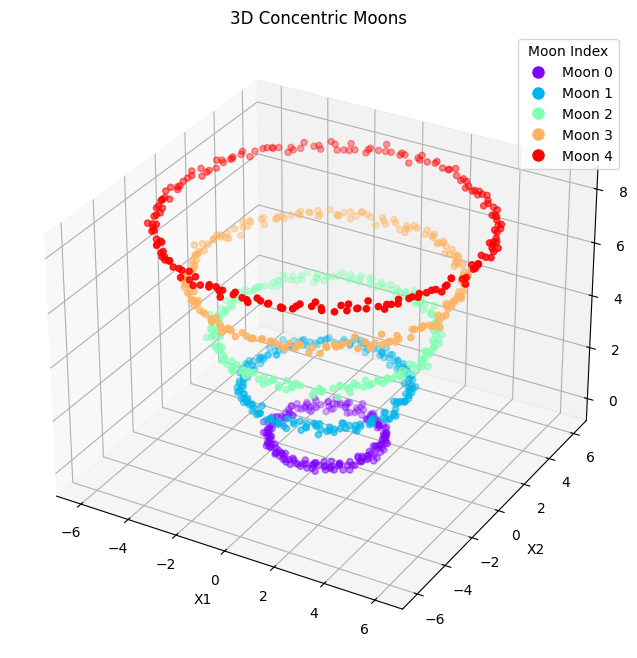

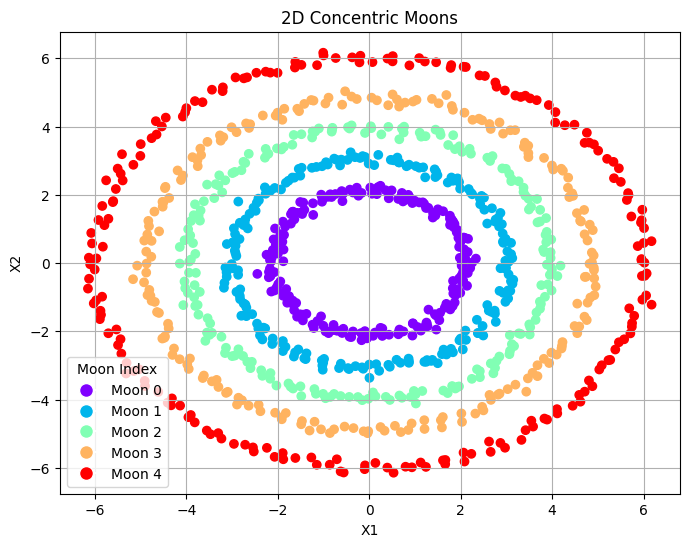

In [4]:
X, y = generate_concentric_moons()
plot_concentric_moons_3d(X, y)
plot_concentric_moons_2d(X[:, :2], y)

## 5️⃣ **Manual t-SNE Initialization**

`initialize_manual_t_sne(X, perplexity=15)`: Initializes a custom t-SNE object with the specified perplexity.
  - Computes pairwise distances and similarities.
  - Generates the low-dimensional mapping.
  - Optimizes the embedding using gradient descent.
  - Tracks and returns the execution time for performance comparison.

This function streamlines the manual t-SNE setup, ensuring consistency in initialization and optimization.

In [5]:
def initialize_manual_t_sne(X, perplexity:int = 15):
    """
    Initializes a manual t-SNE object with a given perplexity.
    """
    start = time.time()
    t_sne = SNE(perplexity, X)
    t_sne.compute_pairwise_distances()
    t_sne.compute_pairwise_similarities(True)
    t_sne.compute_low_dimensional_mapping()
    t_sne.optimize_embedding()
    end = time.time()
    custom_duration = end - start
    return t_sne, custom_duration

## 📌 **Implement t-SNE from Scratch**

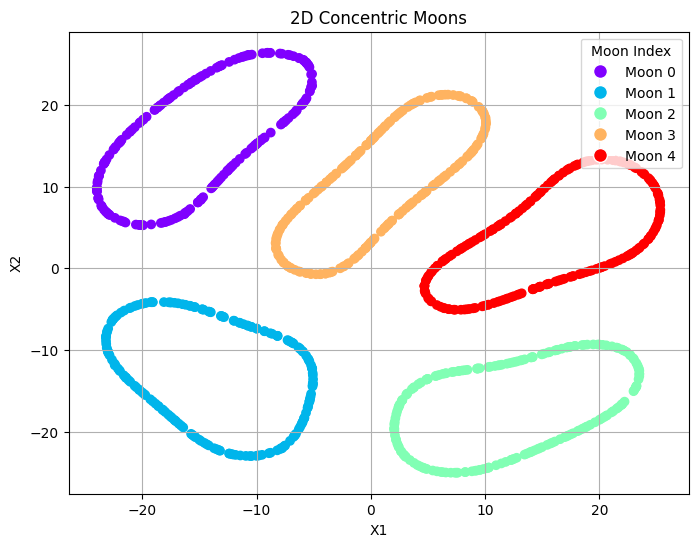

Manual t-SNE execution time: 61.8039 seconds


In [6]:
manual_t_sne, duration = initialize_manual_t_sne(X)
plot_concentric_moons_2d(manual_t_sne.mapping, y)
print(f"Manual t-SNE execution time: {duration:.4f} seconds")

## 📌 **Compare with Scikit-Learn' t-SNE**

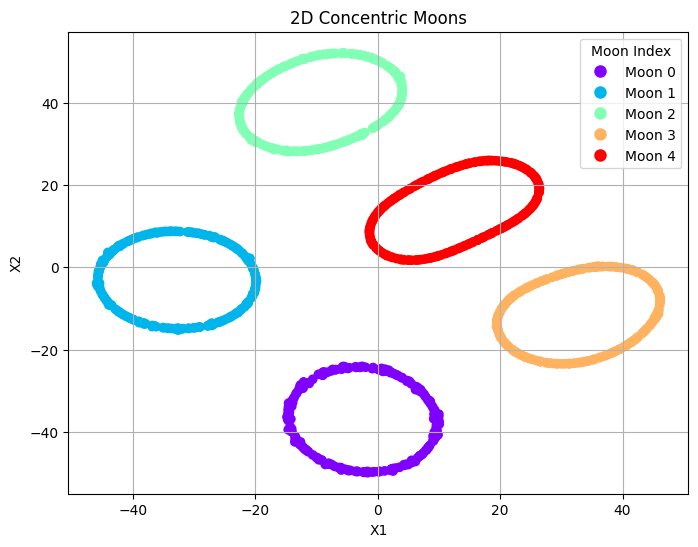

Sklearn t-SNE execution time: 1.8638 seconds


In [7]:
start = time.time()
tsne = sklearnTSNE(n_components=2, perplexity=15, max_iter=500, learning_rate=200)
X_embedded = tsne.fit_transform(X)
end = time.time()
sklearn_duration = end - start

plot_concentric_moons_2d(X_embedded, y)
print(f"Sklearn t-SNE execution time: {sklearn_duration:.4f} seconds")

## 📌 **Comparing Manual and Scikit-learn t-SNE**

- Calculates **Euclidean distances** for both manual and Scikit-learn t-SNE embeddings.
- Flattens the distance matrices for a direct comparison.
- Computes the **correlation** between the two distance sets to evaluate similarity.
- Prints the correlation score, offering a quantitative measure of alignment between the two methods.

This comparison helps validate the manual implementation's accuracy by contrasting it with the established Scikit-learn approach.


In [8]:
manual_distance = euclidean_distances(manual_t_sne.mapping)
sklearn_distance = euclidean_distances(X_embedded)

manual_t = manual_distance.flatten()
sklearn_t = sklearn_distance.flatten()

correlation =  1 - correlation(manual_t, sklearn_t)
print(f"Correlation between Manual and Sklearn t-SNE: {correlation:.4f}")

Correlation between Manual and Sklearn t-SNE: 0.6363


## 📌 **Compare with Scikit-Learn's PCA**

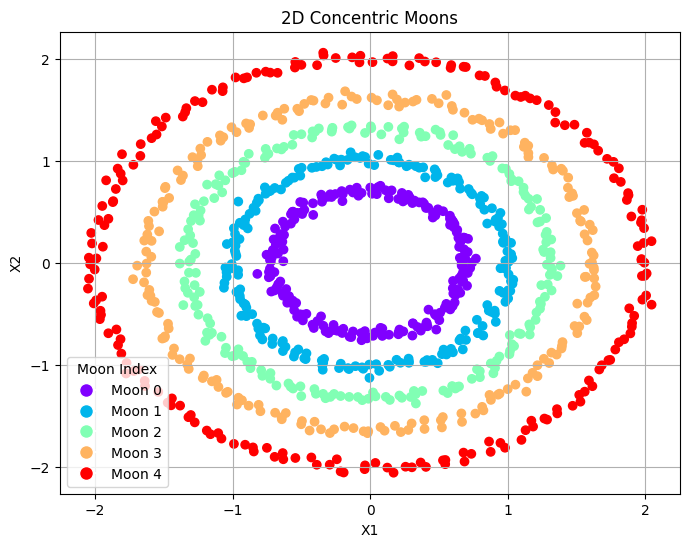

Sklearn PCA execution time: 0.0037 seconds


In [9]:
start = time.time()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_scaled)
end = time.time()
pca_duration = end - start

plot_concentric_moons_2d(X_scaled[:, :2], y)
print(f"Sklearn PCA execution time: {pca_duration:.4f} seconds")

## 📌 **Visualization and Analysis**
1️⃣ **Original High-Dimensional Dataset (3D Plot):**

The original dataset is visualized in a 3D plot, showcasing five concentric moons. Each moon is represented at a different level along the Z-axis, providing clear spatial separation. The structure is well-defined, demonstrating the dataset's inherent complexity in three dimensions.

2️⃣ **Manual t-SNE Implementation:**

The manual t-SNE implementation effectively reduces the data to two dimensions, capturing distinct clusters for each moon. However, the shapes of the clusters are irregular, indicating that while local structures (clustering) are preserved, the global geometric arrangement is somewhat distorted. This is common in manual implementations where optimization might require fine-tuning for better preservation of shapes.

3️⃣ **Scikit-learn t-SNE Implementation:**
Scikit-learn's t-SNE produces more regular, circular clusters, demonstrating better optimization. The separation between clusters is clear, and the uniform shapes suggest that the local structures are better preserved than in the manual implementation. However, global structures (relative positioning of clusters) might still be distorted, as t-SNE focuses on maintaining local neighbor relations.

4️⃣ **PCA Visualization:**

PCA, being a linear dimensionality reduction method, preserves the global structure of the data. The concentric circles clearly represent the original dataset's structure, maintaining the order and relative distances between the moons. However, PCA doesn't handle complex nonlinear structures well, which is why the distinct cluster separation seen in t-SNE is less apparent here.



---



## 📌 **Perplexity Exploration**
Experiment with various perplexity values and analyze
their impact on clustering and separation. Visualize the trade-offs between local and global structure preservation.

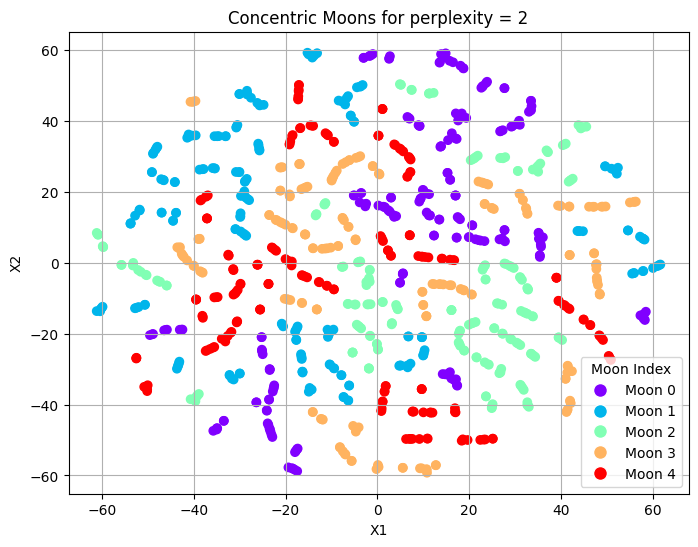

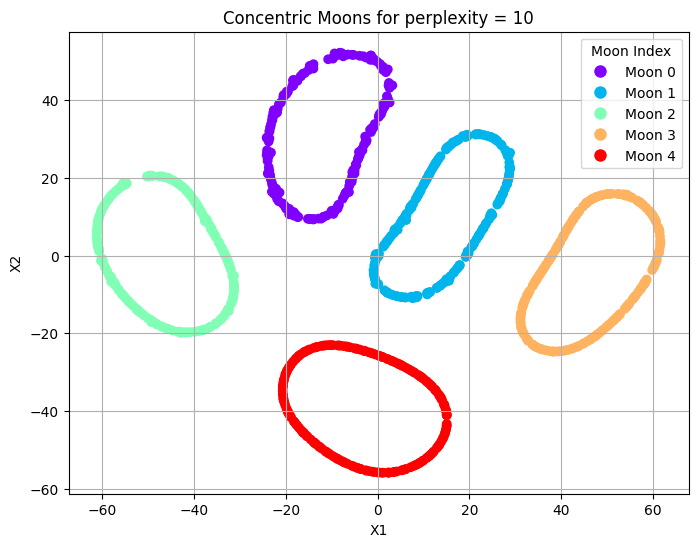

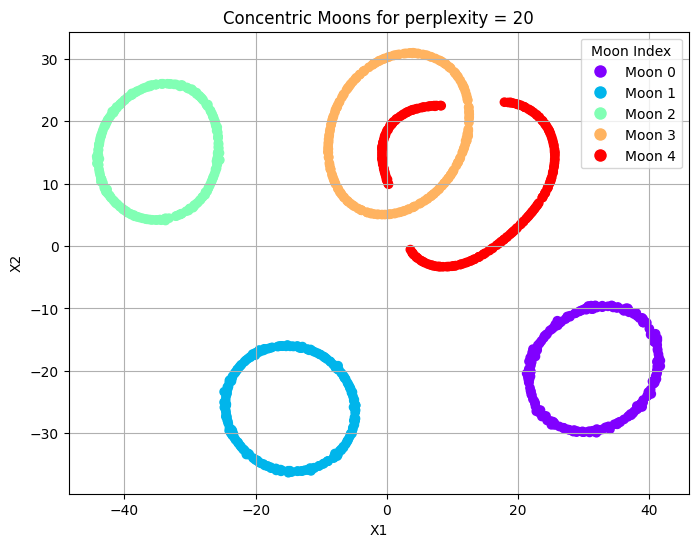

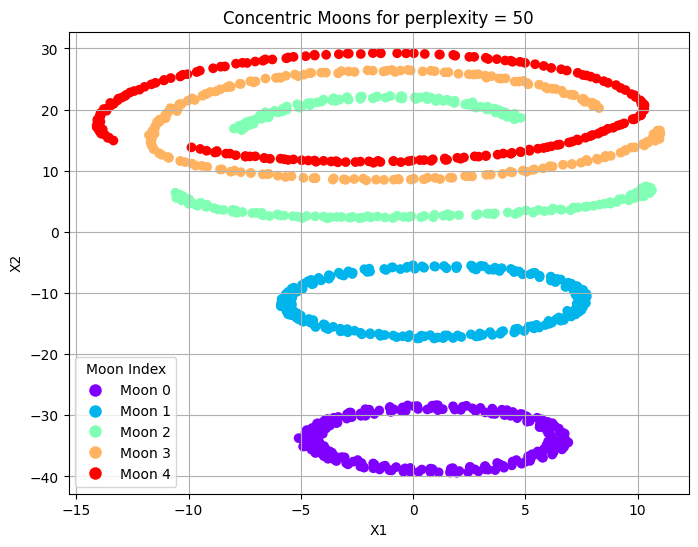

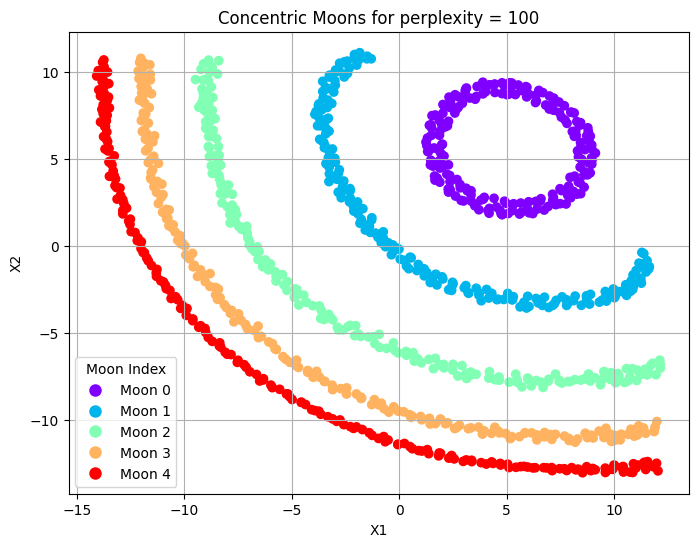

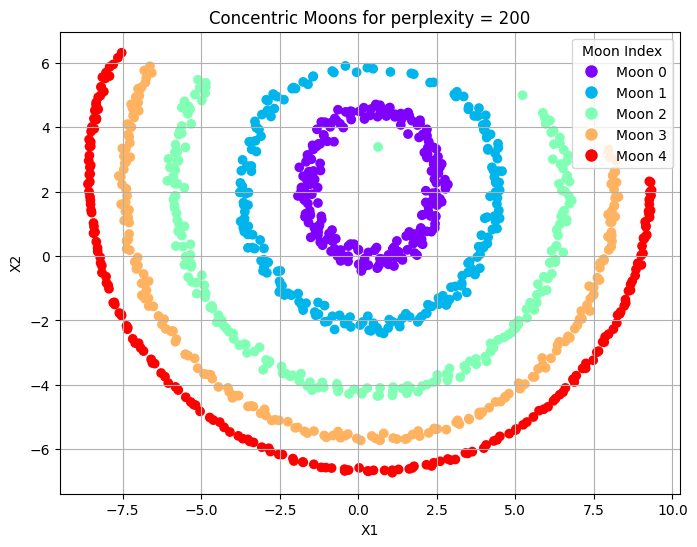

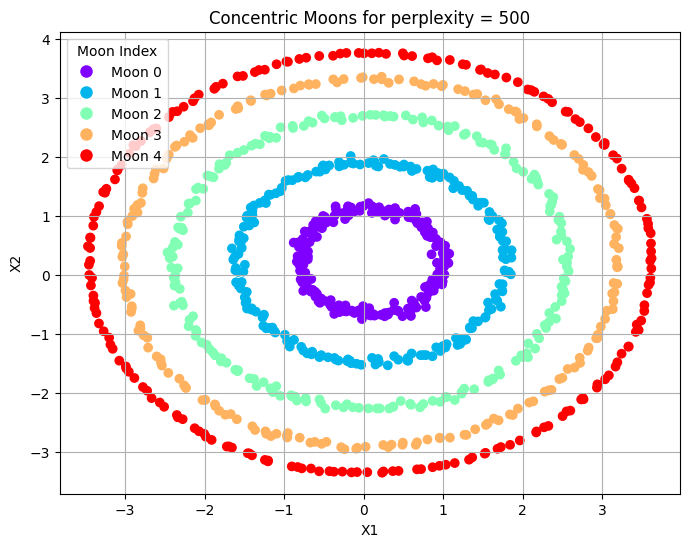

In [10]:
for perplexity in [2, 10, 20, 50, 100, 200, 500]:
    tsne = sklearnTSNE(n_components=2, perplexity=perplexity, max_iter=500, learning_rate=200)
    X_embedded = tsne.fit_transform(X)

    plot_concentric_moons_2d(X_embedded, y, f"Concentric Moons for perplexity = {perplexity}")

## 📌 **Distance Metrics Analysis**
Investigate the effect of using alternative distance metrics
(e.g., cosine similarity) on the resulting embeddings. Compare the results and
discuss any improvements or distortions in cluster formation.

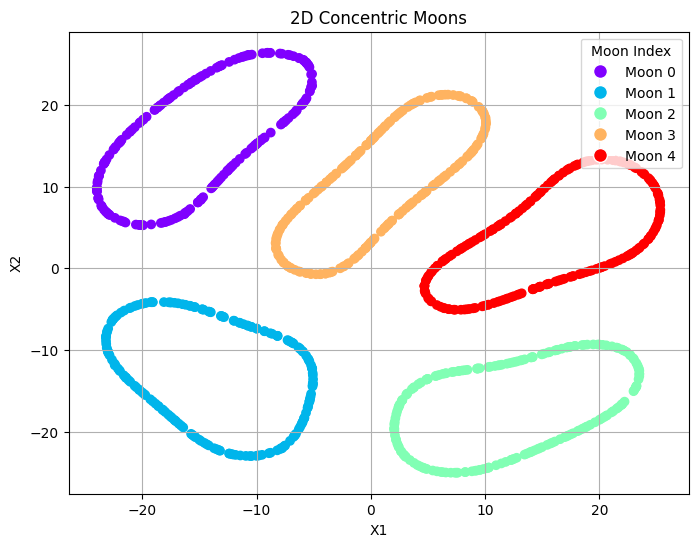

In [11]:
t_sne = SNE(perplexity, X)
t_sne.compute_pairwise_distances("cosine")
t_sne.compute_pairwise_similarities(True)
t_sne.compute_low_dimensional_mapping()
t_sne.optimize_embedding()
plot_concentric_moons_2d(manual_t_sne.mapping, y)

## **Conclusion**

PCA preserves global structures but struggles with complex clustering. t-SNE, particularly Scikit-learn's optimized version, excels at capturing local structures and distinct clusters. The manual t-SNE implementation performs well but requires further tuning for improved accuracy. The choice of technique depends on whether global structure (PCA) or local clustering (t-SNE) is the priority.